In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import roc_auc_score
from IPython.display import display

%matplotlib inline

Prepare Data

In [279]:
credit_scoring_dir = '../dataset/credit_scoring.csv'

df = pd.read_csv(credit_scoring_dir)

df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')

In [280]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [281]:
status_values = {1:'ok', 2:'default', 0:'unk'}

df['status'] = df['status'].map(status_values)

In [282]:
home_values = {1:'rent', 2:'owner', 3:'private', 4:'ignore', 5:'parents', 6:'other', 6:'unk'}

df['home'] = df['home'].map(home_values)

In [283]:
marital_values = {1:'single', 2:'married', 3:'widow', 4:'separated', 5:'divorced', 6:'unk'}

df['marital'] = df['marital'].map(marital_values)

In [284]:
records_values = {1:'no', 2:'yes', 0:'unk'}

df['records'] = df['records'].map(records_values)

In [285]:
job_values = {1:'fixed', 2:'partime', 3:'freelance', 4:'others', 0:'unk'}

df['job'] = df['job'].map(job_values)

In [286]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [287]:
df.describe()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.000000,4455.000000,4455.000000,4455.000000,4.455000e+03,4.455000e+03,4.455000e+03,4455.000000,4455.000000
mean,7.987205,46.441751,37.077666,55.568799,7.633170e+05,1.060341e+06,4.043820e+05,1039.021773,1462.875645
std,8.173444,14.655225,10.984856,19.515878,8.703625e+06,1.021757e+07,6.344253e+06,474.543007,628.089913
min,0.000000,6.000000,18.000000,35.000000,0.000000e+00,0.000000e+00,0.000000e+00,100.000000,105.000000
25%,2.000000,36.000000,28.000000,35.000000,8.000000e+01,0.000000e+00,0.000000e+00,700.000000,1117.500000
50%,5.000000,48.000000,36.000000,51.000000,1.200000e+02,3.500000e+03,0.000000e+00,1000.000000,1400.000000
75%,12.000000,60.000000,45.000000,72.000000,1.660000e+02,6.000000e+03,0.000000e+00,1300.000000,1692.000000
max,48.000000,72.000000,68.000000,180.000000,1.000000e+08,1.000000e+08,1.000000e+08,5000.000000,11140.000000


In [288]:
for c in ['income', 'assets', 'debt']:

    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [289]:
df = df[df['status'] != 'unk']

df = df.fillna(0)

Split Data (Train, Val, Test)

In [290]:
X = pd.get_dummies(df.drop(columns='status'))

y = df['status']

In [291]:
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=11)

In [292]:
y_full_train = (y_full_train == 'default').astype(int)

y_train = (y_train == 'default').astype(int)

y_val = (y_val == 'default').astype(int)

y_test = (y_test == 'default').astype(int)

In [293]:
X_test.columns

Index(['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
       'amount', 'price', 'home_0', 'home_ignore', 'home_owner',
       'home_parents', 'home_private', 'home_rent', 'home_unk', 'marital_0',
       'marital_divorced', 'marital_married', 'marital_separated',
       'marital_single', 'marital_widow', 'records_no', 'records_yes',
       'job_fixed', 'job_freelance', 'job_others', 'job_partime', 'job_unk'],
      dtype='object')

Decision Tree

In [294]:
def assess_risk(client):
    if client['records_yes'] == True:
        if client['job_partime'] == True:
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [295]:
xi = X_train.iloc[0].to_dict()

In [296]:
assess_risk(xi)

'ok'

In [297]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [298]:
y_proba = dt.predict_proba(X_val)[:, 1]

y_pred = (y_proba >= 0.5).astype(int)

In [299]:
roc_auc_score(y_val, y_proba)

np.float64(0.6616484221743236)

In [300]:
y_proba = dt.predict_proba(X_train)[:, 1]

roc_auc_score(y_train, y_proba)

np.float64(1.0)

In [301]:
dt = DecisionTreeClassifier(max_depth=2)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [302]:
y_proba = dt.predict_proba(X_train)[:, 1]

roc_auc_score(y_train, y_proba)

np.float64(0.7054989859726213)

In [303]:
y_proba = dt.predict_proba(X_val)[:, 1]

y_pred = (y_proba >= 0.5).astype(int)

roc_auc_score(y_val, y_proba)

np.float64(0.6685264343319367)

In [304]:
print(export_text(dt, feature_names=X_train.columns))

|--- records_no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records_no >  0.50
|   |--- job_partime <= 0.50
|   |   |--- class: 0
|   |--- job_partime >  0.50
|   |   |--- class: 1



Decision Tree learning algorithm

In [305]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default']
]

In [306]:
df_example = pd.DataFrame(data, columns=['assets', 'status'])

df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [307]:
Ts = [2000, 3000, 4000, 5000, 8000]

In [308]:
for t in [4000]:

    df_left = df_example[df_example['assets'] <= t]
    df_right = df_example[df_example['assets'] > t]

    display(df_left)
    display(df_right)

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


In [309]:
for t in Ts:

    df_left = df_example[df_example['assets'] <= t]
    df_right = df_example[df_example['assets'] > t]

    display(df_left)
    display(df_right)


,assets,status
1,2000,default
2,0,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


,assets,status
1,2000,default
2,0,default
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
0,8000,default
6,9000,ok


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
6,9000,ok


Decision Tree parameter tuning

In [310]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:

    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_proba = dt.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_proba)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.754
  10 -> 0.685
  15 -> 0.653
  20 -> 0.659
None -> 0.661


In [311]:
scores = []

for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_proba = dt.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_proba)

        scores.append((d, s, auc))

In [312]:
scores_df = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])

In [313]:
scores_df.head()

,max_depth,min_samples_leaf,auc
0,4,1,0.761283
1,4,2,0.761283
2,4,5,0.761283
3,4,10,0.761283
4,4,15,0.763726


In [314]:
scores_df_pivot = scores_df.pivot(index='min_samples_leaf', columns='max_depth', values='auc')

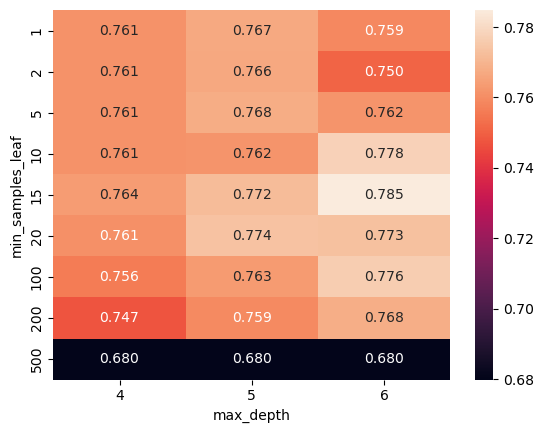

In [317]:
sns.heatmap(scores_df_pivot, annot=True, fmt='.3f')

plt.show()